# Weather data Prediction using TF2.0

### Importing libraries.

In [1]:
import os
import datetime

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [3]:
import tensorflow as tf

In [6]:
tf.__version__

'2.0.0'

In [4]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

### Importing data.

The data is downloaded from [source](https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip). The data can be downloaded and placed in the project or it can be done directly using following commands:


In [12]:
DATA_PATH = '../Data'

In [13]:
df = pd.read_csv(os.path.join(DATA_PATH, 'jena_climate_2009_2016.csv'))
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### Basic EDA with preprocessing and making the data ready for input to model


In [14]:
#slice [start:stop:step], from index 5 taking every 6th record (sub sampling data as the values are for eery 10mins converting data to every hour values)
df = df[5::6]

#storing date time values in a separate variable for future processing
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

df.head()


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


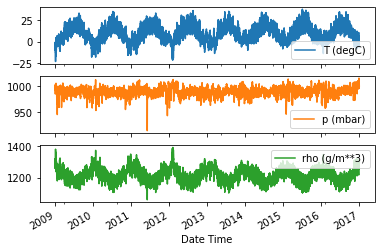

In [15]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots= True)

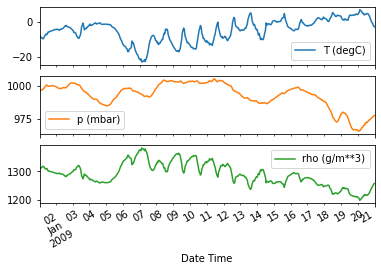

In [16]:
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]

_ = plot_features.plot(subplots = True)

Data cleaning

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


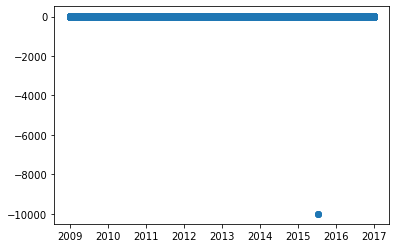

In [21]:
plt.scatter(date_time,df['wv (m/s)'])

In [23]:
#select garbage -9999.0 values of wv and max_wv and replacing them with 0
wv = df['wv (m/s)']
bad_wv = wv== -9999.0
wv[bad_wv] = 0.0 #replacing low NA values of wv with 0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

#sanity check
df['wv (m/s)'].min()

0.0

Found certain useful features after doing EDA on the data. Adding those features to the data.

In [24]:
wv= df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# convert to radians
wd_rad = df.pop('wd (deg)') * np.pi / 180

# Calculate the x and y components of the wind velocity
df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

# Calculate the x and y components of max wind velocity
df['max Wx'] = max_wv * np.cos(wd_rad)
df['max Wy'] = max_wv * np.sin(wd_rad)

Converting date time into multiple features

In [25]:
timestamp_sec = date_time.map(datetime.datetime.timestamp)

day = 24 * 60 * 60
year = (365.2425) * day

df['Day sin'] = np.sin(timestamp_sec * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_sec * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_sec * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_sec * (2 * np.pi / year))

Splitting data into train:val:test in 70:20:10

In [26]:
# Dictionary of column names and their indices
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
#  Splitting the dataset with a 70:30:10 split
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
# Number of features in our dataset
num_features = df.shape[1]

Normalizing data

In [27]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

##### Creating data window